### 워크플로우 커스터마이징 기법
- 사용자 정의 측정 지표 전달
- fit() 메서드에 콜백을 전달하여 훈련하는 동안 특정 시점에 수행될 행동 예약

## 1. 사용자 정의 지표 만들기

- keras.metrics 모듈에 포함되어 있지 않은 지표의 경우 사용자 정의
- 케라스 지표는 keras.metrics.Metric 클래스를 상속한 클래스
- 층과 마찬가지로 지표는 텐서플로 변수에 내부 상태 저장
- 층과 다른 점은 이 변수가 역전파로 업데이트되지 않음 -> 상태 업데이트 로직을 update_state() 메서드 안에 직접 작성

### Metric 클래스를 상속하여 RMSE 사용자 정의 지표 구현

In [21]:
import tensorflow as tf

class RootMeanSquaredError(keras.metrics.Metric):
    
    # 생성자에서 상태 변수 정의, 층과 마찬가지로 add_weight() 메서드 사용
    def __init__(self, name="rmse", **kwargs):
        super().__init__(name=name, **kwargs)
        self.mse_sum = self.add_weight(name="mse_sum", initializer="zeros")
        self.total_samples = self.add_weight(
            name="total_samples", initializer="zeros", dtype="int32"
        )

    # update_state() 메서드 안에 상태 업데이트 로직 구현
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        mse = tf.reduce_sum(tf.square(y_true - y_pred))
        self.mse_sum.assign_add(mse)
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)

    # result() 메서드로 현재 지표 값 반환
    def result(self):
        return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))

    # 객체를 다시 생성하지 않고 상태 초기화 
        # - 지표 객체 하나를 서로 다른 훈련 반복에 사용, 훈련과 평가에 모두 사용
    def reset_state(self):
        self.mse_sum.assign(0.)
        self.total_samples.assign(0)

### 사용자 정의 지표 테스트

In [22]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

def get_mnist_model():
    inputs = keras.Input(shape=(28*28,))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features)
    model = keras.Model(inputs, outputs)
    return model

(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28*28)).astype("float32")/255
test_images = test_images.reshape((10000, 28*28)).astype("float32")/255
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

model = get_mnist_model()
model.compile(optimizer="rmsprop",
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy", RootMeanSquaredError()])
model.fit(train_images, train_labels,
         epochs=3,
         validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)

Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8638 - loss: 0.4463 - rmse: 0.4390 - val_accuracy: 0.9597 - val_loss: 0.1416 - val_rmse: 0.2477
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9529 - loss: 0.1660 - rmse: 0.2703 - val_accuracy: 0.9694 - val_loss: 0.1107 - val_rmse: 0.2178
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9635 - loss: 0.1286 - rmse: 0.2374 - val_accuracy: 0.9708 - val_loss: 0.1026 - val_rmse: 0.2084
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9656 - loss: 0.1151 - rmse: 0.2230


## 2. 사용자 정의 콜백

- 내장 콜백에서 제공하지 않는 특정 행동이 훈련 도중 필요할 경우 사용자 정의
- keras.callbacks.Callback 클래스를 상속받아 구현
- 이름에서 알 수 있듯이 훈련 동안 여러 지점에서 호출될 메서드를 구현
  - on_epoch_begin(epoch, logs) : 각 에포크가 시작할 때 호출
  - on_epoch_end(epoch, logs) : 각 에포크가 끝날 때 호출
  - on_batch_begin(batch, logs) : 각 배치 처리 시작 전 호출
  - on_batch_end(batch, logs) : 각 배치 처리 끝난 후 호출
  - on_train_begin(logs) : 훈련 시작 시 호출
  - on_train_end(logs) : 훈련 종료 시 호출
- 메서드들은 모두 logs 매개변수와 함께 호출
- 이 매개변수 값은 이전 배치, 에포크 또는 훈련 실행에 대한 정보(훈련과 검증 지표 등)가 담긴 딕셔너리

In [23]:
# 훈련 도중 배치 손실 값을 리스트에 추가하고 에포크 끝에서 이 값을 그래프로 저장

from matplotlib import pyplot as plt

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []
    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))
    def on_epoch_end(self, epoch, logs):
        plt.clf()
        plt.plot(range(len(self.per_batch_losses)), self.per_batch_losses,
                label="Training loss for each batch")
        plt.xlabel(f"Batch (epoch {epoch})")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(f"plot_at_epoch_{epoch}")
        self.per_batch_losses = []

### 사용자 정의 콜백 테스트

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8665 - loss: 0.4462 - val_accuracy: 0.9576 - val_loss: 0.1448
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9521 - loss: 0.1631 - val_accuracy: 0.9670 - val_loss: 0.1120
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9625 - loss: 0.1316 - val_accuracy: 0.9714 - val_loss: 0.1051
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9668 - loss: 0.1157 - val_accuracy: 0.9737 - val_loss: 0.1020
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9717 - loss: 0.1033 - val_accuracy: 0.9769 - val_loss: 0.0952
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9757 - loss: 0.0911 - val_accuracy: 0.9759 - val_loss: 0.0994
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9763 - loss: 0.0879 - val_accuracy: 0.9767 - val_loss: 0.0981
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9781 - loss: 0.0792 

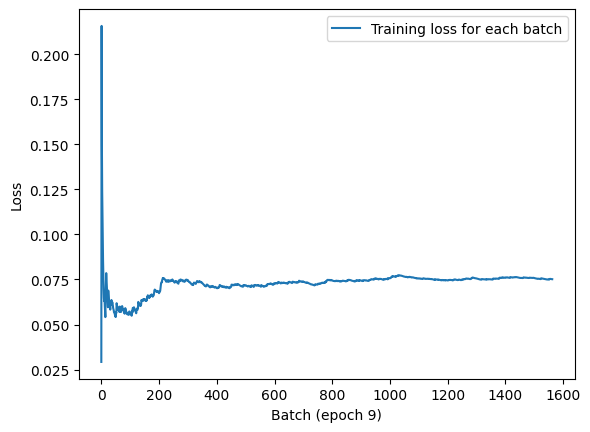

In [24]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

def get_mnist_model():
    inputs = keras.Input(shape=(28*28,))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features)
    model = keras.Model(inputs, outputs)
    return model

(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28*28)).astype("float32")/255
test_images = test_images.reshape((10000, 28*28)).astype("float32")/255
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]


model = get_mnist_model()
model.compile(optimizer="rmsprop",
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])
model.fit(train_images, train_labels,
         epochs=10, 
         callbacks=[LossHistory()],
         validation_data=(val_images, val_labels))

## 참고) TensorBoard 콜백

In [25]:
import os

tensorboard_dir = '/kaggle/working/tensorboard'
os.makedirs(tensorboard_dir, exist_ok=True)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8617 - loss: 0.4532 - val_accuracy: 0.9577 - val_loss: 0.1483
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9501 - loss: 0.1678 - val_accuracy: 0.9673 - val_loss: 0.1168
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9624 - loss: 0.1278 - val_accuracy: 0.9724 - val_loss: 0.0973
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9700 - loss: 0.1063 - val_accuracy: 0.9749 - val_loss: 0.0915
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9713 - loss: 0.1014 - val_accuracy: 0.9756 - val_loss: 0.0933
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9740 - loss: 0.0903 - val_accuracy: 0.9782 - val_loss: 0.0850
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9774 - loss: 0.0883 - val_accuracy: 0.9775 - val_loss: 0.0913
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9782 - loss: 0.076

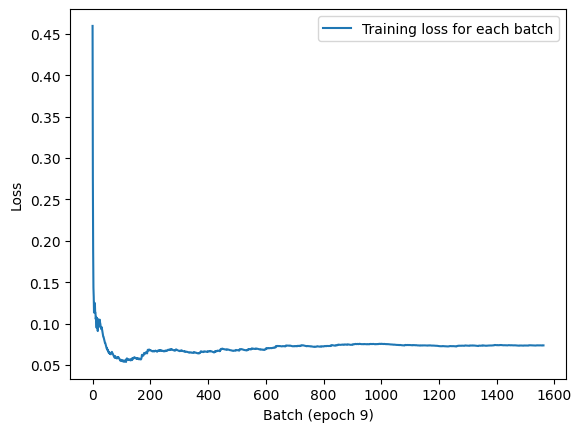

In [26]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])
tensorboard = keras.callbacks.TensorBoard(
    log_dir="/kaggle/working/tensorboard",
)
model.fit(train_images, train_labels,
         epochs=10, 
         callbacks=[LossHistory()],
         validation_data=(val_images, val_labels))

## 회고

앞서 배웠던 예제 중에 기억이 맞는다면 RMSE를 그냥 수식 처리해서 사용했던 것 같은데, Metric 클래스를 상속한 RMSE 클래스를 만들어 일관된 평가 지표를 사용할 수 있게 되었습니다.   
또한 기존에는 EarlyStopping 이라는 것이 있다는 정도만 알고 사용했었는데, 콜백의 일종임을 알게 되었습니다.   
아쉬운 점이 있다면 마지막에 텐서보드 인터페이스에서 훈련과 평가 지표를 실시간 그래프로 모니터링하는 실습이 있어 수행해보고 싶었는데 노트북을 작성한 kaggle 환경에서는 텐서보드 인터페이스가 실행이 안 되는 것 같아 아쉬움이 남습니다.